# PREDICTING CUSTOMER RETENTION

In this notebook, I will be predicting customer churn for a Telco business using deep learning models.

Dataset: https://www.kaggle.com/blastchar/telco-customer-churn

View on Github: https://github.com/ehannell/customer_retention

## Import Libraries

In [103]:
#Data Modulation
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Traditional Machine Learning
import sklearn
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


#Deep learning 
import tensorflow as tf
from tensorflow import keras

## Load Data

The dataset is stored in the project's Github repository, which allow for easy data retrieval. The code is reproducable without having to download the dataset locally.

In [104]:
#url to the dataset
url = 'https://raw.githubusercontent.com/ehannell/customer_retention/main/Data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

#create dataframe
df = pd.read_csv(url, error_bad_lines=False)

## Check & Manipulate the Data

In [105]:
#Summary of all the variables, along with missing values, data type, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [106]:
#Build function to check unique values in our "object" variables
def variable_values(df):
    for column in df:
        if df[column].dtypes=='object':
            print(f'{column} : {df[column].unique()}')

In [107]:
#Check the values of each variable
variable_values(df)

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges : ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn : ['No' 'Yes']


- Notice that TotalCharges actually contains numerical data. We learn that this column needs to be transformed numerical. 
- Note also that we have values like "No phone services", which seems to be similar to a simple "No". This should also be fixed

In [108]:
#Transform TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

In [109]:
#Replace "No internet" with "No"
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

In [110]:
#check cleaned dataset
variable_values(df)

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes']
OnlineBackup : ['Yes' 'No']
DeviceProtection : ['No' 'Yes']
TechSupport : ['No' 'Yes']
StreamingTV : ['No' 'Yes']
StreamingMovies : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [111]:
#Drop CustomerID because it's unncessary for building our model
df.drop('customerID', axis='columns', inplace=True, errors='ignore')

In [112]:
#confirm that we don't have any missing values
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [113]:
#Notice that we now have 11 rows of missing values for TotalCharges. We'll drop these because there are so few.
df = df.dropna()

In [114]:
#explore the first 5 rows of data
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [115]:
#explore the bottom 5 rows of data
df.tail(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes
7042,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.50,No


# EXPLORATORY DATA ANALYSIS
This part of the project let's us explore the characteristics of all the dataset variables. Hence, we get an understanding for which variables could be relevant in building the actual model.

In [116]:
#Explore the statistical nature of our continuous variables
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


No     5163
Yes    1869
Name: Churn, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


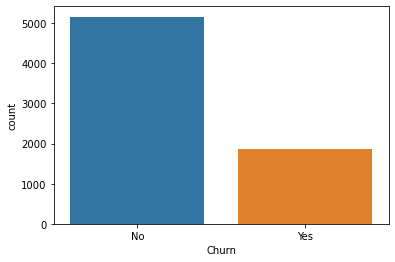

In [117]:
#Check the distribution of customers that churned and remained 
print(df['Churn'].value_counts())
print(sns.countplot(x='Churn', data=df))

In [118]:
#Closer look at the share of Yes vs. No
Remained = df[df.Churn == 'Yes'].shape[0]
Churned = df[df.Churn == 'No'].shape[0]

Total_customers = Remained + Churned
Remained_ratio = ( Remained / Total_customers) * 100
Churned_ratio = ( Churned / Total_customers) * 100
 
print("{:.2f}".format(Remained_ratio),'% of individuals remained as customer.')
print("{:.2f}".format(Churned_ratio),'% of individuals ended their relationship with the company.')
print('')
print('This means that we have a 73% chance of correctly guessing if that client left the company.')

26.58 % of individuals remained as customer.
73.42 % of individuals ended their relationship with the company.

This means that we have a 73% chance of correctly guessing if that client left the company.


<AxesSubplot:xlabel='InternetService', ylabel='count'>

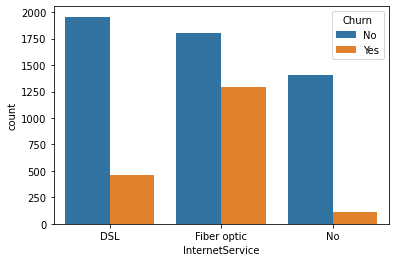

In [119]:
#Visualize distribution of churn count for certain classes
sns.countplot(x='InternetService', hue='Churn', data = df)

Tenure: Customers who have been with the company for long appear to remain a client
MonthlyCharges: In general, it seesm like clients who stayed pay a lower amount of monthly charges,
TotalCharges: However, it seems like TotalCharges follow a more similar pattern


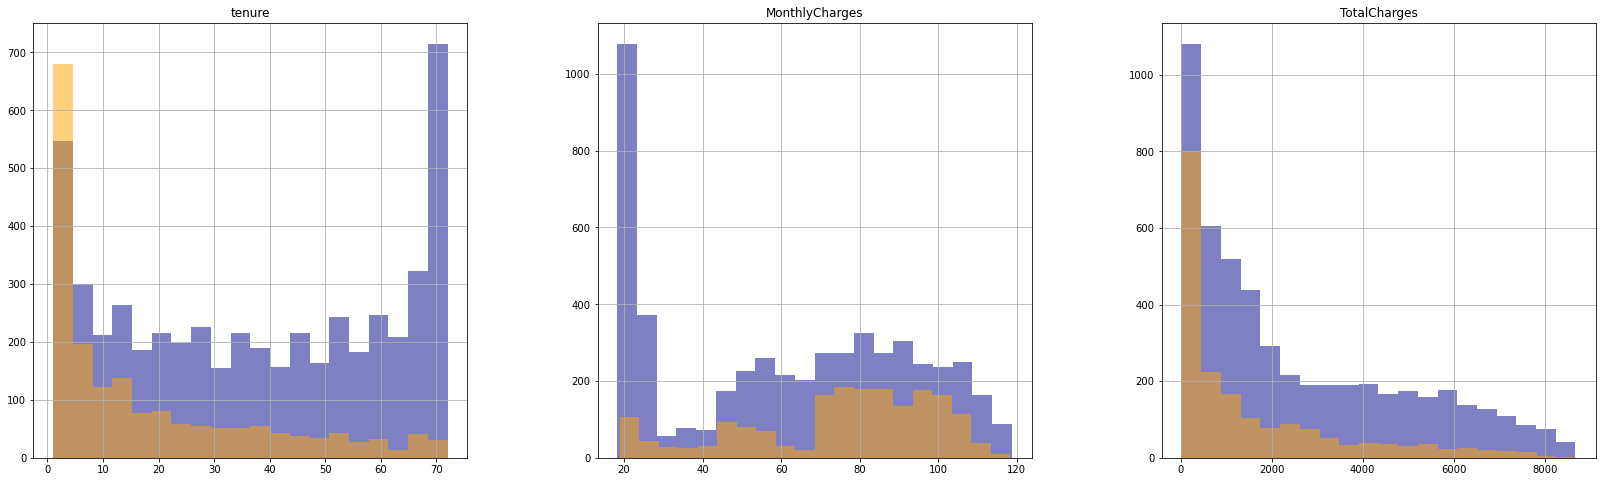

In [120]:
#Explore the numerical value distribution by churn variable
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, ax = plt.subplots(1,3,figsize=(28,8))
df[df.Churn == 'No'][numerical_features].hist(bins=20, color='darkblue', alpha=0.5, ax = ax)
df[df.Churn == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax = ax)

print('Tenure: Customers who have been with the company for long appear to remain a client')
print('MonthlyCharges: In general, it seesm like clients who stayed pay a lower amount of monthly charges,')
print('TotalCharges: However, it seems like TotalCharges follow a more similar pattern')

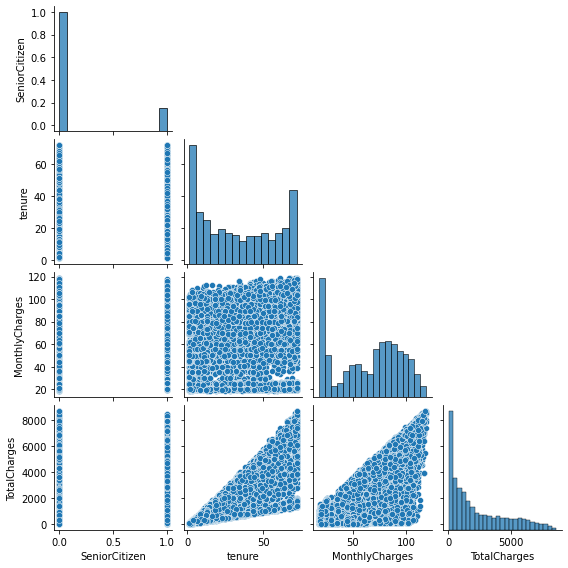

In [121]:
#Correlation Matrix
g = sns.pairplot(df, height=2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

### Data Exploring Takeaways
1. We see that our classes are imbalanced, which means that we would be 

## Prepare Data for Machine Learning

In order to run the data through the machine learning models that we will be building, we need transform the dataset values from text to numerical. 

### Label Encode Target Variable

In [122]:
#Transform Yes/No to 1/0 to allow computation
le = preprocessing.LabelEncoder()
le.fit(df['Churn'])
df['Churn'] = le.transform(df['Churn'])
df.Churn

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int32

In [123]:
variable_values(df)

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes']
OnlineBackup : ['Yes' 'No']
DeviceProtection : ['No' 'Yes']
TechSupport : ['No' 'Yes']
StreamingTV : ['No' 'Yes']
StreamingMovies : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


### Label Encode Binary Variables

In [124]:
#Looking at our unqiue values above, we see that there are a lot of binary variables
#These will also be label encoded
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [84]:
#Encode all the binary variables
encoder = MultiColumnLabelEncoder(columns = ['gender','Partner', 'Dependents', 'PhoneService',
                                   'MultipleLines', 'OnlineSecurity','OnlineBackup',
                                   'DeviceProtection','TechSupport','StreamingTV',
                                   'StreamingMovies','PaperlessBilling'])

df = encoder.fit_transform(df)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,DSL,1,0,1,1,1,1,One year,1,Mailed check,84.80,1990.50,0
7039,0,0,1,1,72,1,1,Fiber optic,0,1,1,0,1,1,One year,1,Credit card (automatic),103.20,7362.90,0
7040,0,0,1,1,11,0,0,DSL,1,0,0,0,0,0,Month-to-month,1,Electronic check,29.60,346.45,0
7041,1,1,1,0,4,1,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Mailed check,74.40,306.60,1


### OneHotEncode Multiclass Variables

In [85]:
#Transform the multiclass feature variables to dummies to allow computation
def to_dummy(data, column):
    #data = pd.get_dummies(data=df, columns=['InternetService'])
    return pd.get_dummies(data=data, columns=[column], drop_first=True) 

In [86]:
df = to_dummy(df, 'Contract')
df = to_dummy(df, 'InternetService')
df = to_dummy(df, 'PaymentMethod')

In [87]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,Contract_One year,Contract_Two year,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,1,0,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,1,0,0,0,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,0,1,...,84.80,1990.50,0,1,0,0,0,0,0,1
7039,0,0,1,1,72,1,1,0,1,1,...,103.20,7362.90,0,1,0,1,0,1,0,0
7040,0,0,1,1,11,0,0,1,0,0,...,29.60,346.45,0,0,0,0,0,0,1,0
7041,1,1,1,0,4,1,1,0,0,0,...,74.40,306.60,1,0,0,1,0,0,0,1


In [88]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'Contract_One year', 'Contract_Two year', 'InternetService_Fiber optic',
       'InternetService_No', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

### Split Data into Training and Test

In [89]:
#drop the approval (classifiction) variable from data
feature_data = df.drop('Churn', 1)

#create independent variable data and target arrays
X = np.asarray(feature_data)
y = np.asarray(df['Churn'])

#X = feature_data
#y = df['Churn']

#split the data and check the shapes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((5625, 23), (5625,), (1407, 23), (1407,))

# STATISTICAL MACHINE LEARNING MODELS

The first machine learning section of this notebook consists of a statistical traditional model.

## MODEL 1 - Logistic Regression

In [90]:
logistic = LogisticRegression()

#Build pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                        ('logistic', logistic)])

In [91]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression())])

In [92]:
pipe.score(X_test, y_test)

0.7874911158493249

### Hyperparameter Tuning
Find out which settings to use to achieve the best possible model

In [94]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('logistic', LogisticRegression())],
 'verbose': False,
 'scaler': StandardScaler(),
 'logistic': LogisticRegression(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'logistic__C': 1.0,
 'logistic__class_weight': None,
 'logistic__dual': False,
 'logistic__fit_intercept': True,
 'logistic__intercept_scaling': 1,
 'logistic__l1_ratio': None,
 'logistic__max_iter': 100,
 'logistic__multi_class': 'auto',
 'logistic__n_jobs': None,
 'logistic__penalty': 'l2',
 'logistic__random_state': None,
 'logistic__solver': 'lbfgs',
 'logistic__tol': 0.0001,
 'logistic__verbose': 0,
 'logistic__warm_start': False}

In [95]:
# Build the parameter grid
param_grid = {
    'logistic__C': np.logspace(-10, -4, 4, 10),
    'logistic__penalty':['l2','l1','elasticnet'],
    'logistic__class_weight':['balanced','none'],
    'logistic__solver':['lbfgs','newton-cg','liblinear','sag','saga'],
    'logistic__max_iter':[100, 1000, 2500, 5000]
}

In [96]:
#search the grid
best_logreg = GridSearchCV(pipe, param_grid,
                      scoring='f1_micro',
                      n_jobs=-1)
best_logreg.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logistic__C': array([1.e-10, 1.e-08, 1.e-06, 1.e-04]),
                         'logistic__class_weight': ['balanced', 'none'],
                         'logistic__max_iter': [100, 1000, 2500, 5000],
                         'logistic__penalty': ['l2', 'l1', 'elasticnet'],
                         'logistic__solver': ['lbfgs', 'newton-cg', 'liblinear',
                                              'sag', 'saga']},
             scoring='f1_micro')

In [97]:
#analyze gridsearch model
print(best_logreg.best_params_)
print("Best parameter (CV score=%0.3f):" % best_logreg.best_score_)

{'logistic__C': 1e-06, 'logistic__class_weight': 'balanced', 'logistic__max_iter': 2500, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}
Best parameter (CV score=0.756):


In [98]:
#Build new pipeline using the best hyperparameter settings
logistic = LogisticRegression(class_weight='balanced',
                              max_iter=100, 
                              penalty='l2',
                              solver='sag')

#Build pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                        ('logistic', logistic)])

In [99]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(class_weight='balanced', solver='sag'))])

In [100]:
pipe.score(X_test, y_test)

0.7313432835820896

### Visualize Logistic Regression Model

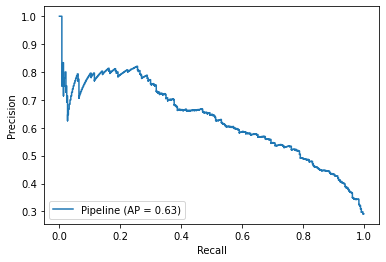

In [101]:
#Precision / Recall Curve
disp = plot_precision_recall_curve(pipe, X_test, y_test)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.832


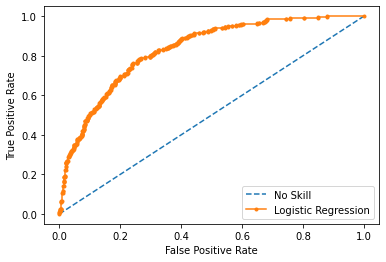

In [102]:
#ROC Curve
ns_probs = [0 for _ in range(len(y_test))]

lr_probs = pipe.predict_proba(X_test)

lr_probs = lr_probs[:, 1]


# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Evaluate Logistitc Regression Model

In [42]:
y_pred = pipe.predict(X_test)

In [43]:
#print classifciation report along with confusiong matrix
print('Classification Report:')
print(classification_report(y_test, y_pred))
print(' ')
print('Confusion Matrix:'),
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      1407

 
Confusion Matrix:
[[733 300]
 [ 78 296]]


Text(33.0, 0.5, 'True Values')

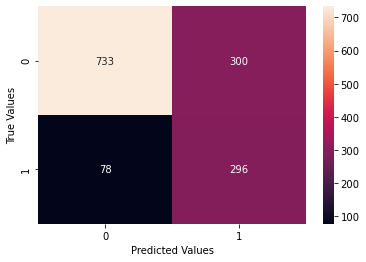

In [44]:
#Confusion Matrix
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)

plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

### Logistic Regression Model Conslusion

The logistic regression performs well when it comes to predicting the churned customers. However, the overall performance is poor, particularly when it comes to the precision of customers how remained.

## MODEL 2 - Random Forest

In [45]:
rf = RandomForestClassifier()
#find what hyperparameters are used to adjust random forest
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [46]:
param_grid = {
    'n_estimators': [50, 250, 500],
    'max_features': ['sqrt', 0.25, 1.0],
    'min_samples_split': [2, 4, 6]
}

In [47]:
# Instantiate the grid search model
grid_search=GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=2, n_jobs=-1, verbose=2)

# NOTE: Heavy computation in next cell

In [48]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   36.2s finished


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 0.25, 1.0],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 250, 500]},
             verbose=2)

In [49]:
#Get best hyperparameters
grid_search.best_params_

{'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 500}

In [51]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = model.score(test_features, test_labels)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [52]:
best_random = grid_search.best_estimator_
grid_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.2068 degrees.
Accuracy = 0.79%.


C:\Users\erikh\.conda\envs\customer_retention\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\erikh\.conda\envs\customer_retention\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [58]:
y_pred = best_random.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.65      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



Text(33.0, 0.5, 'True Values')

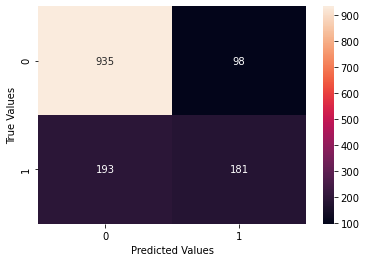

In [59]:
#Confusion Matrix
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)

plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

# DEEP LEARNING MODEL

The second machine learning section of this notebook consists of a deep learning model.

In [713]:
dl_model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(26,),activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

In [714]:
dl_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model_history = dl_model.fit(x=X_train, 
                             y=y_train, 
                             epochs=10,
                             validation_split=0.2)

Train on 4500 samples, validate on 1125 samples
Epoch 1/10
4500/4500 [==============================] - 1s 159us/sample - loss: 33.6370 - accuracy: 0.6393 - val_loss: 2.7589 - val_accuracy: 0.7511
Epoch 2/10
4500/4500 [==============================] - 0s 60us/sample - loss: 9.4330 - accuracy: 0.6647 - val_loss: 0.7158 - val_accuracy: 0.7484
Epoch 3/10
4500/4500 [==============================] - 0s 54us/sample - loss: 3.1779 - accuracy: 0.6887 - val_loss: 0.6123 - val_accuracy: 0.7707
Epoch 4/10
4500/4500 [==============================] - 0s 54us/sample - loss: 1.7004 - accuracy: 0.7193 - val_loss: 0.6170 - val_accuracy: 0.7609
Epoch 5/10
4500/4500 [==============================] - 0s 64us/sample - loss: 0.9992 - accuracy: 0.7358 - val_loss: 0.6150 - val_accuracy: 0.7529
Epoch 6/10
4500/4500 [==============================] - 0s 62us/sample - loss: 0.9009 - accuracy: 0.7433 - val_loss: 0.5584 - val_accuracy: 0.7493
Epoch 7/10
4500/4500 [==============================] - 0s 66us/samp

### Visualzie Deep Learning Model Performance

Text(0, 0.5, 'accuracy')

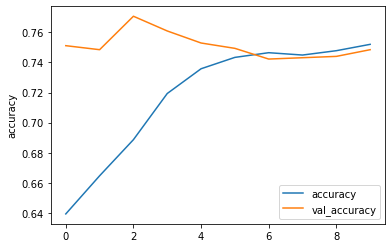

In [715]:
# Visualize accuracy history
df_result = pd.DataFrame(model_history.history)
df_result[['accuracy', 'val_accuracy']].plot()
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

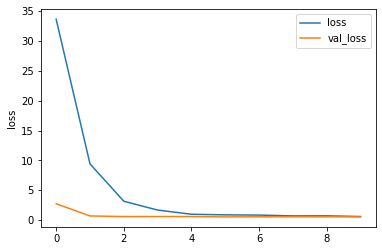

In [716]:
# Visualize loss history
df_result[['loss', 'val_loss']].plot()
plt.ylabel('loss')

### Deep Learning Evaluation & Prediction

In [563]:
#Evaluate the model on our test dataset
dl_model.evaluate(X_test, y_test)

1407/1407 [==============================] - 0s 31us/sample - loss: 0.8548 - accuracy: 0.7669


[0.8548404391386362, 0.76687986]

In [564]:
#Make predictions based on X_test data
y_pred = dl_model.predict(X_test)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

y_pred

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [566]:
#Run classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       999
           1       0.68      0.37      0.48       408

    accuracy                           0.77      1407
   macro avg       0.73      0.65      0.66      1407
weighted avg       0.75      0.77      0.74      1407



Text(33.0, 0.5, 'True Values')

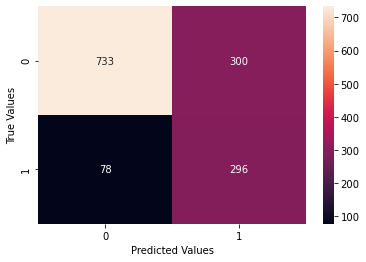

In [800]:
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)

plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

### Deep Learning Model Conslusion

Judging by the classification report and confusion matrix, we see that our deep learning model is performing reasonably well, but not great.

## Model Comparison Conclusion